In [1]:
!git clone -b normalizing-flow https://github.com/AlexanderNevarko/glo-flow.git

Cloning into 'glo-flow'...
remote: Enumerating objects: 319, done.
remote: Counting objects: 100% (319/319), done.
remote: Compressing objects: 100% (205/205), done.
remote: Total 319 (delta 176), reused 238 (delta 100), pack-reused 0
Receiving objects: 100% (319/319), 802.45 KiB | 6.98 MiB/s, done.
Resolving deltas: 100% (176/176), done.


In [2]:
import sys
sys.path.append('/content/glo-flow')
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/glo-flow']

In [3]:
!pip install -q nflows comet_ml

     |████████████████████████████████| 45 kB 1.0 MB/s 
     |████████████████████████████████| 312 kB 9.5 MB/s 
     |████████████████████████████████| 546 kB 6.7 MB/s 
     |████████████████████████████████| 54 kB 1.0 MB/s 
     |████████████████████████████████| 53 kB 1.5 MB/s 


In [4]:
from comet_ml import Experiment
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

import torchvision
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms as tr

from tqdm.notebook import tqdm

In [5]:
BW_METHOD = 0.1

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load the model and get pretrained latents

In [7]:
from modules.dataset import IdxDataset, LatentsDataset, LatentsContextualDataset
from modules.glo_generator import GLOGenerator, GLOModel, SampleGenerator

In [8]:
device = torch.device('cuda')

In [9]:
gen_state_dict = torch.load(
    '/content/drive/MyDrive/GLANN/glo_mnist_models/SOTA_Adam_SparseAdam_z_32_zlr_1e-3_glr_1e-3_100_epochs_model.pth',
map_location=torch.device('cpu'))

# gen_state_dict = torch.load(
#     '/content/drive/MyDrive/GLANN/glo_cifar_models/Adam_SparseAdam_Ada_strategy_3_1_model.pth',
# map_location=torch.device('cpu'))

In [10]:
latents = gen_state_dict['z.weight']

In [11]:
N_COMPONENTS = latents.shape[1]
latents.shape

torch.Size([60000, 32])

In [12]:
dataset = LatentsDataset(latents)
lat_loader = DataLoader(dataset, batch_size=64, shuffle=False)

In [13]:
mnist_train = IdxDataset(MNIST(root='datasets', train=True, transform=tr.ToTensor(), download=True))
sampler_init_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=False)

generator = GLOGenerator(min_channels=16,
                         max_channels=128,
                         noise_channels=N_COMPONENTS,
                         num_blocks=3,
                         dataloader=sampler_init_train_loader,
                         normalization='ada',
                         lrelu_slope=0).to(device)
sample_generator = SampleGenerator(sampler_init_train_loader, z_dim=N_COMPONENTS, bw_method=BW_METHOD)
model = GLOModel(generator, sampler_init_train_loader, sample_generator, sparse=True).to(device)

# cifar_train = IdxDataset(CIFAR10(root='datasets', train=True, transform=tr.ToTensor(), download=True))
# sampler_init_train_loader = DataLoader(cifar_train, batch_size=64, shuffle=False)

# generator = GLOGenerator(min_channels=128,
#                          max_channels=1024,
#                          noise_channels=N_COMPONENTS,
#                          num_blocks=3,
#                          dataloader=sampler_init_train_loader,
#                          normalization='ada',
#                          lrelu_slope=0).to(device)
# sample_generator = SampleGenerator(sampler_init_train_loader, z_dim=N_COMPONENTS, bw_method=BW_METHOD)
# model = GLOModel(generator, sampler_init_train_loader, sample_generator, sparse=True).to(device)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/train-images-idx3-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/MNIST/raw



In [14]:
model.load_state_dict(gen_state_dict)
model.to(device)
model.eval()
for param in model.parameters():
    param.requires_grad_(False)

### Flow model

In [15]:
from nflows import transforms, distributions, flows

In [16]:
num_layers = 10
transformations = []
for _ in range(num_layers):
    transformations.append(transforms.ReversePermutation(features=N_COMPONENTS))
    transformations.append(transforms.MaskedAffineAutoregressiveTransform(features=N_COMPONENTS, 
                                                                          hidden_features=128,
                                                                          use_batch_norm=True))
transform = transforms.CompositeTransform(transformations)
base_distribution = distributions.StandardNormal(shape=[N_COMPONENTS])
flow = flows.Flow(transform=transform, distribution=base_distribution).to(device)

In [17]:
optimizer = torch.optim.Adam(flow.parameters())
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [100, 150], gamma=0.2)

### Gaussian model

In [18]:
from sklearn.mixture import GaussianMixture

In [19]:
gm = GaussianMixture(n_components=1, covariance_type='full').fit(latents.cpu())

### Let's train

In [20]:
from modules.train_flow import FlowTrainer

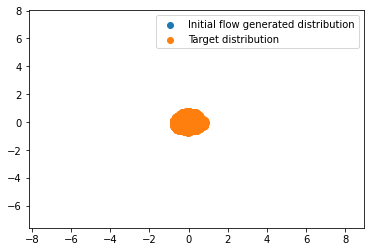

In [21]:
samples = flow.sample(1_000).detach().cpu().numpy()
plt.scatter(samples[:, 0], samples[:, 1], label='Initial flow generated distribution')
plt.scatter(latents[:, 0].detach().cpu().numpy(), latents[:, 1].detach().cpu().numpy(), label='Target distribution')
plt.xlim(left=min(latents[:, 0].cpu().numpy())*10, right=max(latents[:, 0].cpu().numpy())*10)
plt.ylim(bottom=min(latents[:, 1].cpu().numpy())*10, top=max(latents[:, 1].cpu().numpy())*10)
plt.legend()
plt.show()

In [22]:
experiment = Experiment(api_key='CfFmqDpTCtsdDkLooedZh7bs2',
                        project_name='flow',
                        workspace='alexandernevarko',
                        auto_metric_logging=False)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/alexandernevarko/flow/5cd782a3b2d84e43b4a283cfd4e7a410



In [23]:
trainer = FlowTrainer(flow, logger=experiment, generator_model=model, basic_model=gm)

In [24]:
trainer.train(200, lat_loader, optimizer, scheduler=scheduler, 
              exp_name='mnist_10_32_128_bn_strategy_2', model_path='/content/drive/MyDrive/GLANN/flow_mnist')

  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 0 train loss: -15.143093839954973


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.



  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 1 train loss: -20.34837523909774


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 2 train loss: -21.529813494001115


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 3 train loss: -22.265145259117013


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 4 train loss: -22.7946727972295


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 5 train loss: -23.214597205871712


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 6 train loss: -23.565887528441863


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 7 train loss: -23.861979063640018


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 8 train loss: -24.122155421324123


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 9 train loss: -24.349412590710084


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 10 train loss: -24.546521621980645


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 11 train loss: -24.72861490269968


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 12 train loss: -24.90268813013268


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 13 train loss: -25.056523083115437


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 14 train loss: -25.201746503427337


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 15 train loss: -25.330927017146845


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 16 train loss: -25.466548946112205


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 17 train loss: -25.575107733069707


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 18 train loss: -25.687640208425297


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 19 train loss: -25.77340325312828


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 20 train loss: -25.86424684422865


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 21 train loss: -25.94305144800052


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 22 train loss: -26.02186325821541


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 23 train loss: -26.106401449581707


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 24 train loss: -26.181403967363238


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 25 train loss: -26.261204762245292


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 26 train loss: -26.314468965347388


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 27 train loss: -26.381622452725733


  0%|          | 0/938 [00:00<?, ?it/s]

Average epoch 28 train loss: -26.44326193754607


  0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [25]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/alexandernevarko/flow/5cd782a3b2d84e43b4a283cfd4e7a410
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Average epoch train loss [29] : (-26.44326193754607, -15.143093839954973)
COMET INFO:     Train loss [27651]            : (-30.480995178222656, 146.39065551757812)
COMET INFO:   Others:
COMET INFO:     Name         : mnist_10_32_128_bn_strategy_2
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1-kXAfMEuAo-hZ-Qj8LZJ3NLB85mZoPhh
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     images              : 29
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 2
COMET INFO:     os packages         : 1
COMET INFO:     so

### Inference with generator

In [ ]:
from modules.glo_generator import GLOGenerator, GLOModel, SampleGenerator
from modules.dataset import IdxDataset

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [ ]:
inverse_transform = tr.ToPILImage()

In [ ]:
mnist_train = MNIST(root='datasets', train=True, transform=tr.ToTensor(), download=True)

In [ ]:
mnist_train = IdxDataset(mnist_train)

In [ ]:
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=1, pin_memory=True)
sampler_init_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=False)

In [ ]:
N_COMPONENTS = 32
BW_METHOD = 0.1
generator = GLOGenerator(min_channels=16,
                         max_channels=128,
                         noise_channels=N_COMPONENTS,
                         num_blocks=3,
                         dataloader=train_loader,
                         normalization='ada',
                         lrelu_slope=0).to(device)
sample_generator = SampleGenerator(sampler_init_train_loader, z_dim=N_COMPONENTS, bw_method=BW_METHOD)
model = GLOModel(generator, train_loader, sample_generator, sparse=True).to(device)

In [ ]:
model.load_state_dict(gen_state_dict)

<All keys matched successfully>

In [ ]:
base_distribution.sample(10).shape

torch.Size([10, 32])

In [ ]:
res = model(inputs=flow.sample(10))

In [ ]:
imgs = []
for tensor_res in res:
    img = inverse_transform(tensor_res)
    imgs.append(img)

In [ ]:
for img in imgs:
    plt.imshow(img)
    plt.show()

#### GLO article inference
Single full-covariance Gaussian fitted into the latents distribution

In [ ]:
inverse_transform = tr.ToPILImage()

In [ ]:
gm = GaussianMixture(n_components=1, covariance_type='full').fit(latents.cpu())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning:

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.



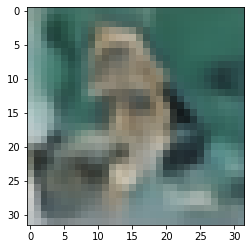

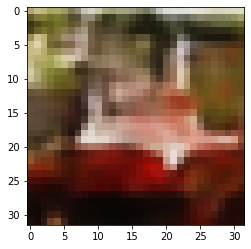

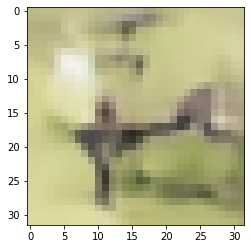

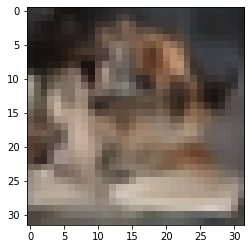

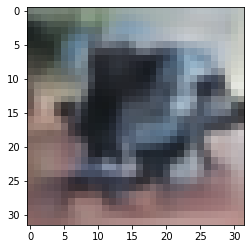

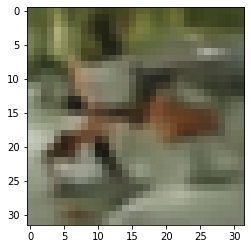

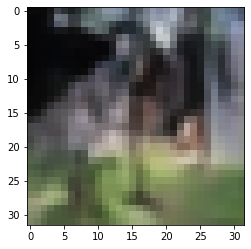

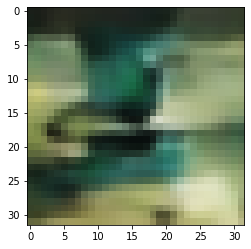

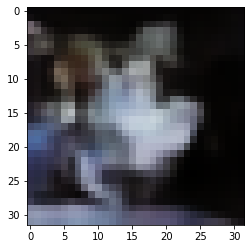

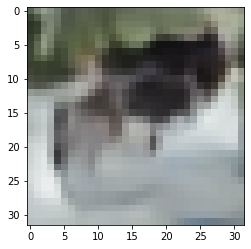

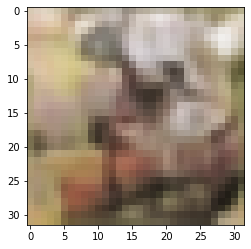

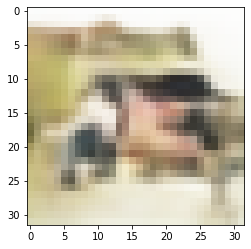

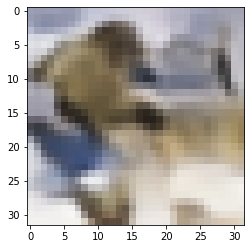

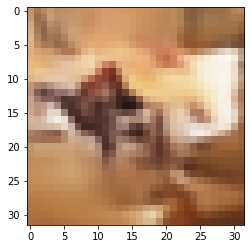

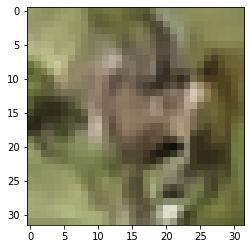

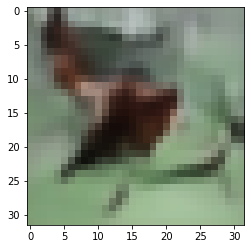

In [ ]:
gm_res = model(inputs=torch.tensor(gm.sample(16)[0], dtype=torch.float).to(device))
for tensor_res in gm_res:
    img = inverse_transform(tensor_res.to('cpu'))
    plt.imshow(img)
    plt.show()